# Multiple Output Models using Keras Functional API

In the first part of this notebook, the Keras functional API is used to train a dual-output model utilizing the **[Wine Quality Dataset](https://archive.ics.uci.edu/ml/datasets/Wine+Quality)** from the UCI machine learning repository. This dataset comprises separate collections for red and white wines.

While wines are usually classified based on quality ratings in the dataset, I combined the red and white wine data to predict both the quality rating and the wine type (red or white) solely from the attributes provided.

The task of predicting wine quality was approached as a regression problem, and the identification of wine type was handled as a binary classification issue. Here is how the implementation was carried out:

## Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

## Load Dataset

A new column `is_red` is added to the dataframe to represent if the wine is white or red.
- For the white wine dataset the `is_red` column is filled with  zeros (0)
- In the red wine dataset it is filled with ones (1)

In [ ]:
# URL of the white wine dataset
URI = './winequality-white.csv'

# Load the dataset from the URL
white_df = pd.read_csv(URI, sep=";")

# Fill the `is_red` column with zeros.
white_df["is_red"] = 0

# Keep only the first of duplicate items
white_df = white_df.drop_duplicates(keep='first')


In [ ]:
# Print the 1st and 100th values
print(white_df.alcohol[0])
print(white_df.alcohol[100])

8.8
9.1


### Pre-process the red wine dataset

In [ ]:
# URL of the red wine dataset
URI = './winequality-red.csv'

# Load the dataset from the URL
red_df = pd.read_csv(URI, sep=";")

# Fill the `is_red` column with ones.
red_df["is_red"] = 1

# Keep only the first of duplicate items
red_df = red_df.drop_duplicates(keep='first')


In [ ]:
# Print the 1st and 100th values
print(red_df.alcohol[0])
print(red_df.alcohol[100])

9.4
10.2


### Concatenate the datasets

In [ ]:
df = pd.concat([red_df, white_df], ignore_index=True)

In [ ]:
# Print the 1st and 100th values
print(df.alcohol[0])
print(df.alcohol[100])

9.4
9.5


In a real-world scenario, the data should be shuffled, however this is not done in this notebook for reproduceability of results

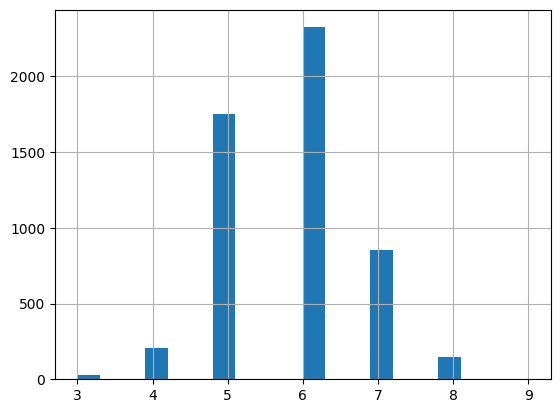

In [ ]:
# Create bar plot for the wines quality
df['quality'].hist(bins=20);

### Imbalanced data
The plot above shows the wine quality dataset is imbalanced.
- Due to the scarcity of observations with a quality rating of 3, 4, 8, or 9, these observations are dropped from the dataset.
- This is achieved by removing data belonging to all classes except those with quality ratings greater than 4 and less than 8.

In [ ]:
# Get data with wine quality greater than 4 and less than 8
df = df[(df['quality'] > 4) & (df['quality'] < 8 )]

# Reset index and drop the old one
df = df.reset_index(drop=True)

In [ ]:
print(df.alcohol[0])
print(df.alcohol[100])

9.4
10.9


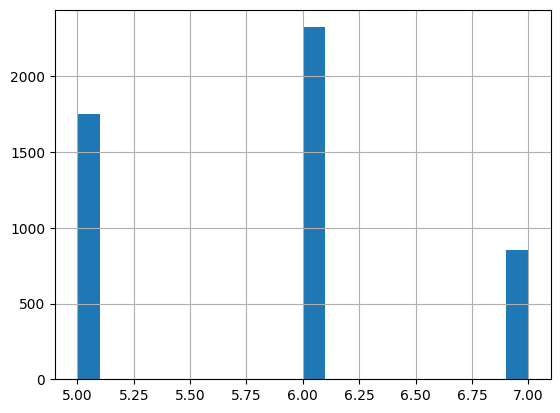

In [ ]:
# Creating bar plot to see new range of data and quality
df['quality'].hist(bins=20);

### Train Test Split

In [ ]:
# Split df into 80:20 train and test sets
train, test = train_test_split(df, test_size=0.2, random_state = 1)

# Split train into 80:20 train and val sets
train, val = train_test_split(train, test_size=0.2, random_state = 1)

In [ ]:
# Exploring training stats
train_stats = train.describe()
train_stats.pop('is_red')
train_stats.pop('quality')
train_stats = train_stats.transpose()

Explore the training stats!

### Get the labels

In [ ]:
def format_output(data):
    is_red = data.pop('is_red')
    is_red = np.array(is_red)
    quality = data.pop('quality')
    quality = np.array(quality)
    return (quality, is_red)

In [ ]:
# Format the output of the train set
train_Y = format_output(train)

# Format the output of the val set
val_Y = format_output(val)

# Format the output of the test set
test_Y = format_output(test)

In [ ]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
225,7.5,0.65,0.18,7.0,0.088,27.0,94.0,0.99915,3.38,0.77,9.4
3557,6.3,0.27,0.29,12.2,0.044,59.0,196.0,0.99782,3.14,0.40,8.8
3825,8.8,0.27,0.25,5.0,0.024,52.0,99.0,0.99250,2.87,0.49,11.4
1740,6.4,0.45,0.07,1.1,0.030,10.0,131.0,0.99050,2.97,0.28,10.8
1221,7.2,0.53,0.13,2.0,0.058,18.0,22.0,0.99573,3.21,0.68,9.9


### Normalize the data

The data is normalized using the formula:
$$x_{norm} = \frac{x - \mu}{\sigma}$$

In [ ]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [ ]:
# Normalize the train set
norm_train_X = norm(train)

# Normalize the val set
norm_val_X = norm(val)

# Normalize the test set
norm_test_X = norm(test)

## Define the Model

In [ ]:
def base_model(inputs):

    # Connect a Dense layer with 128 neurons and a relu activation
    x = Dense(units=128, activation='relu', name='first_dense')(inputs)

    # Connect another Dense layer with 128 neurons and a relu activation
    x = Dense(units=128, activation='relu', name='second_dense')(x)
    return x

# Define output layers of the model (TODO)

We will add output layers to the base model.
- The model will need two outputs.

One output layer will predict wine quality, which is a numeric value.
- Define a `Dense` layer with 1 neuron.
- Since this is a regression output, the activation can be left as its default value `None`.

The other output layer will predict the wine type, which is either red `1` or not red `0` (white).
- Define a `Dense` layer with 1 neuron.
- Since there are two possible categories, we can use a sigmoid activation for binary classification.

Define the `Model`
- Define the `Model` object, and set the following parameters:
  - `inputs`: pass in the inputs to the model as a list.
  - `outputs`: pass in a list of the outputs that we just defined: wine quality, then wine type.
  - **Note**: please list the wine quality before wine type in the outputs, as this will affect the calculated loss if we choose the other order.

In [ ]:
def final_model(inputs):

    # Get the base model
    x = base_model(inputs)

    # Connect the output Dense layer for regression
    wine_quality = Dense(units='1', name='wine_quality')(x)

    # Connect the output Dense layer for classification. this will use a sigmoid activation.
    wine_type = Dense(units='1', activation='sigmoid', name='wine_type')(x)

    # Define the model using the input and output layers
    model = Model(inputs=inputs, outputs=[wine_quality, wine_type], name='')

    return model

## Compiling the Model

In [ ]:
inputs = tf.keras.layers.Input(shape=(11,))
model = final_model(inputs)

model.compile(optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss = {'wine_type' : 'binary_crossentropy',
                      'wine_quality' : 'mean_squared_error'
                     },
              metrics = {'wine_type' : 'accuracy',
                         'wine_quality': tf.keras.metrics.RootMeanSquaredError()
                       }
             )


## Training the Model

In [ ]:
history = model.fit(norm_train_X, train_Y,
                    epochs = 180, validation_data=(norm_val_X, val_Y))

Epoch 1/180
99/99 [==============================] - 3s 13ms/step - loss: 25.1798 - wine_quality_loss: 24.4876 - wine_type_loss: 0.6921 - wine_quality_root_mean_squared_error: 4.9485 - wine_type_accuracy: 0.5040 - val_loss: 17.7830 - val_wine_quality_loss: 17.1202 - val_wine_type_loss: 0.6627 - val_wine_quality_root_mean_squared_error: 4.1377 - val_wine_type_accuracy: 0.7123
Epoch 2/180
99/99 [==============================] - 1s 7ms/step - loss: 12.0022 - wine_quality_loss: 11.3746 - wine_type_loss: 0.6277 - wine_quality_root_mean_squared_error: 3.3726 - wine_type_accuracy: 0.7658 - val_loss: 7.3502 - val_wine_quality_loss: 6.7545 - val_wine_type_loss: 0.5957 - val_wine_quality_root_mean_squared_error: 2.5989 - val_wine_type_accuracy: 0.7554
Epoch 3/180
99/99 [==============================] - 1s 8ms/step - loss: 5.2016 - wine_quality_loss: 4.6623 - wine_type_loss: 0.5393 - wine_quality_root_mean_squared_error: 2.1592 - wine_type_accuracy: 0.7683 - val_loss: 3.3722 - val_wine_quality_

In [ ]:
# Gather the training metrics
loss, wine_quality_loss, wine_type_loss, wine_quality_rmse, wine_type_accuracy = model.evaluate(x=norm_val_X, y=val_Y)

print()
print(f'loss: {loss}')
print(f'wine_quality_loss: {wine_quality_loss}')
print(f'wine_type_loss: {wine_type_loss}')
print(f'wine_quality_rmse: {wine_quality_rmse}')
print(f'wine_type_accuracy: {wine_type_accuracy}')

25/25 [==============================] - 0s 2ms/step - loss: 0.3772 - wine_quality_loss: 0.3505 - wine_type_loss: 0.0266 - wine_quality_root_mean_squared_error: 0.5921 - wine_type_accuracy: 0.9937

loss: 0.3771754801273346
wine_quality_loss: 0.35053932666778564
wine_type_loss: 0.02663608454167843
wine_quality_rmse: 0.5920636057853699
wine_type_accuracy: 0.9936628937721252


## Analyze the Model Performance

In [ ]:
predictions = model.predict(norm_test_X)
quality_pred = predictions[0]
type_pred = predictions[1]

31/31 [==============================] - 0s 2ms/step


In [ ]:
print(quality_pred[0])

[5.6637297]


In [ ]:
print(type_pred[0])
print(type_pred[944])

[0.00015297]
[0.99999535]


### Plotting Functions

Let's define a few functions to visualize performance of the model.

In [ ]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


In [ ]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

In [ ]:
def plot_diff(y_true, y_pred, title = '' ):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.plot([-100, 100], [-100, 100])
    return plt

### Plots for Metrics

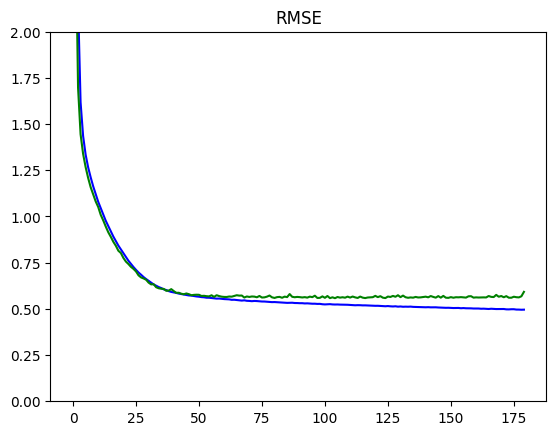

In [ ]:
plot_metrics('wine_quality_root_mean_squared_error', 'RMSE', ylim=2)

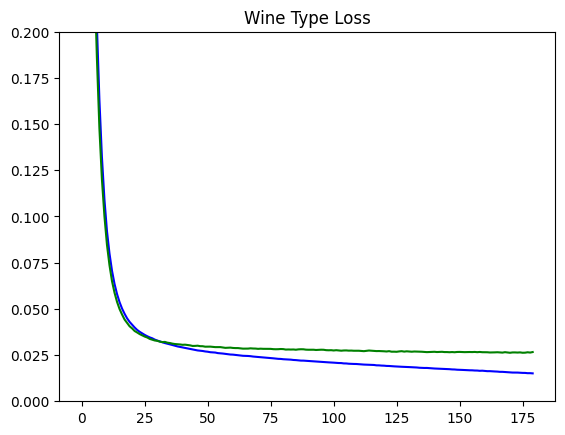

In [ ]:
plot_metrics('wine_type_loss', 'Wine Type Loss', ylim=0.2)

### Plots for Confusion Matrix

Plot the confusion matrices for wine type.

<ipython-input-28-47bb6e202cb0>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-28-47bb6e202cb0>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


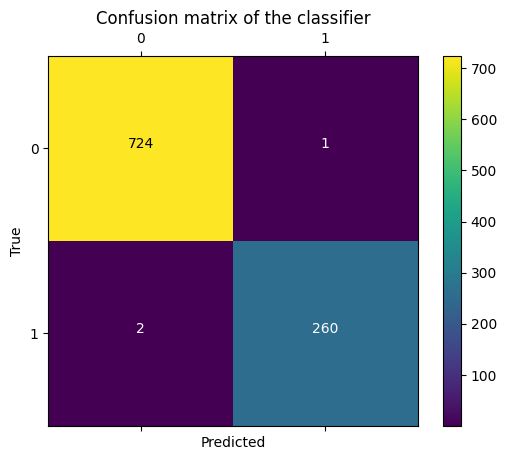

In [ ]:
plot_confusion_matrix(test_Y[1], np.round(type_pred), title='Wine Type', labels = [0, 1])

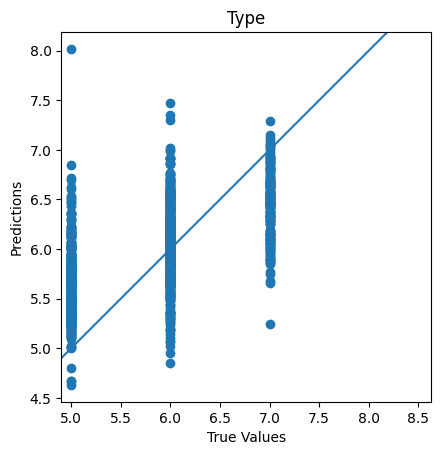

In [ ]:
scatter_plot = plot_diff(test_Y[0], quality_pred, title='Type')

# Build a Multi-output Model for Energy Efficiency Dataset

Now we will use a different dataset Energy Efficiency dataset, another dataset from UCI Machine Learning the Repository, to predict two outputs: Cooling Load and Heating Load

In [ ]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()


# Helper Functions

Let's define a few helper functions to handle data conversion and visualization

In [ ]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

In [ ]:
# Specify data URI
URI = './Energy efficiency dataset.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Building the Model

In [ ]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),), name='input_layer')
first_dense = Dense(units='128', activation='relu', name='first_dense')(input_layer)
second_dense = Dense(units='128', activation='relu', name='second_dense')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu', name='third_dense')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])
model._name = 'energy_model'

print(model.summary())

Model: "energy_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 8)]                  0         []                            
                                                                                                  
 first_dense (Dense)         (None, 128)                  1152      ['input_layer[0][0]']         
                                                                                                  
 second_dense (Dense)        (None, 128)                  16512     ['first_dense[0][0]']         
                                                                                                  
 third_dense (Dense)         (None, 64)                   8256      ['second_dense[0][0]']        
                                                                                       

## Configure hyperparameters and Compile Model

In [ ]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [ ]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=500, validation_data=(norm_test_X, test_Y))

Epoch 1/500
2/2 [==============================] - 1s 324ms/step - loss: 1299.0283 - y1_output_loss: 606.2431 - y2_output_loss: 692.7852 - y1_output_root_mean_squared_error: 24.6220 - y2_output_root_mean_squared_error: 26.3208 - val_loss: 1271.9418 - val_y1_output_loss: 590.7405 - val_y2_output_loss: 681.2012 - val_y1_output_root_mean_squared_error: 24.3052 - val_y2_output_root_mean_squared_error: 26.0998
Epoch 2/500
2/2 [==============================] - 0s 56ms/step - loss: 1248.6324 - y1_output_loss: 579.9647 - y2_output_loss: 668.6677 - y1_output_root_mean_squared_error: 24.0825 - y2_output_root_mean_squared_error: 25.8586 - val_loss: 1212.6555 - val_y1_output_loss: 562.5561 - val_y2_output_loss: 650.0994 - val_y1_output_root_mean_squared_error: 23.7183 - val_y2_output_root_mean_squared_error: 25.4970
Epoch 3/500
2/2 [==============================] - 0s 46ms/step - loss: 1186.6816 - y1_output_loss: 550.7220 - y2_output_loss: 635.9596 - y1_output_root_mean_squared_error: 23.4675 - 

## Evaluate the Model and Plot Metrics

In [ ]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 4ms/step - loss: 20.0176 - y1_output_loss: 8.2183 - y2_output_loss: 11.7992 - y1_output_root_mean_squared_error: 2.8668 - y2_output_root_mean_squared_error: 3.4350
Loss = 20.01755142211914, Y1_loss = 8.21833324432373, Y1_mse = 2.8667635917663574, Y2_loss = 11.799217224121094, Y2_mse = 3.4349987506866455


# Plot the loss and mse

5/5 [==============================] - 0s 3ms/step


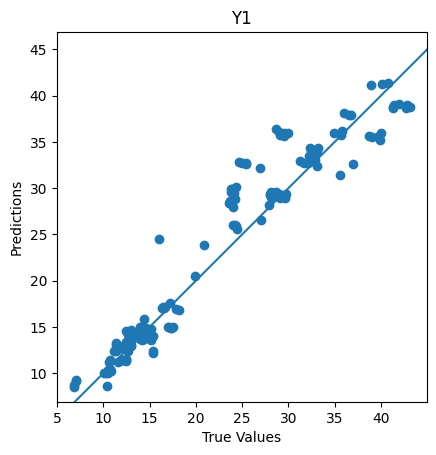

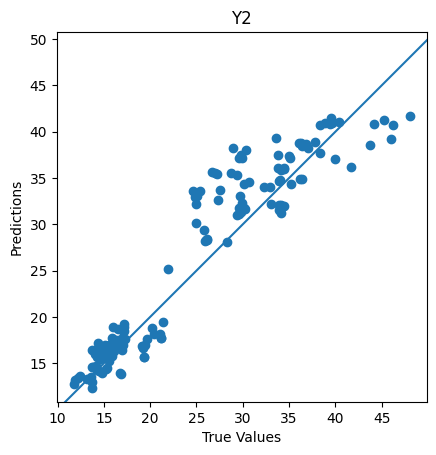

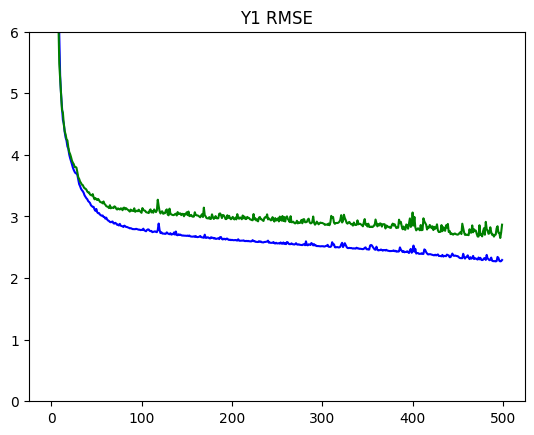

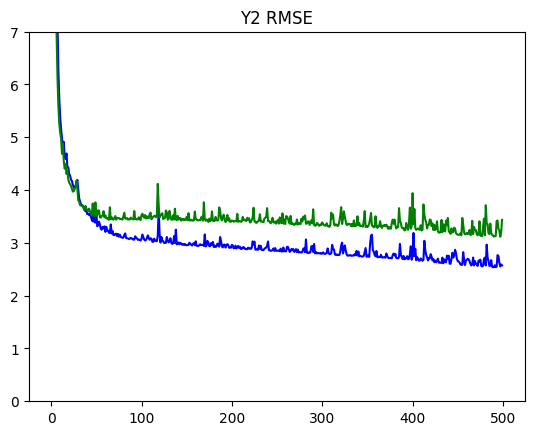

In [ ]:
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)